In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_json("./resources/sentence-compression.jsonl", lines=True)
df_sample = df.sample(5000) 

In [5]:
df_sample

,0,1
139347,With mercury levels rising to the season's hig...,Orissa reels under heat wave conditions
116151,DSS held the whip hand on day one of their Und...,DSS hold the whip
122880,Kim Kardashian apparently always gets what she...,Kim Kardashian gets what she wants with fiance...
32552,"General Growth Properties, Inc. /quotes/zigman...",General Growth Properties announces vice presi...
80052,Bath City endured a nervous 90 minutes against...,Bath City clinch place in Blue Square South pl...
...,...,...
137155,Comic book adventure Iron Man proved its mettl...,Iron Man proves its mettle at box office
150436,"OAO Severstal, one of the world's leading meta...",Severstal completes acquisition of Sparrows Point
128965,"MILEY Cyrus and Liam Hemsworth have split, acc...",Miley Cyrus and Liam Hemsworth have split:
43794,Four St. Johnsbury area residents are facing h...,St. Johnsbury residents face heroin charges


# RNN Model

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50
x = df_sample[0]
y = "sostok " + df_sample[1] + " eostok"

token = Tokenizer()
token.fit_on_texts(x)
token.fit_on_texts(y)

# Helper Functions
def text_to_token(text):
    return token.texts_to_sequences(text)

def token_to_text(tok):
    return token.sequences_to_texts(tok)

x = text_to_token(x)
y = text_to_token(y)

x = pad_sequences(x,  maxlen=max_len, padding='post')
y = pad_sequences(y,  maxlen=max_len, padding='post')

In [7]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.models import Model

latent_dim = 300
embedding_dim = 200

voc = len(token.word_index) + 1 

# Encoder
encoder_inputs = Input(shape=(max_len, ))

# Embedding layer
enc_emb = Embedding(voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 200)   │  3,849,600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 50, 300), │    601,200 │ embedding[0][0]   │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50, 300), │    721,200 │ lstm[0][0]        │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 200) │  3,849,600 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 50, 300), │    721,200 │ lstm_1[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    601,200 │ embedding_1[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  5,793,648 │ lstm_3[0][0]      │
│ (TimeDistributed)   │ 19248)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,137,648 (61.56 MB)

 Trainable params: 16,137,648 (61.56 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

hist = model.fit([x, y[:, :-1]], y[:, 1:], epochs=2, batch_size=128)

Epoch 1/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - loss: 4.9034
Epoch 2/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: 1.4160


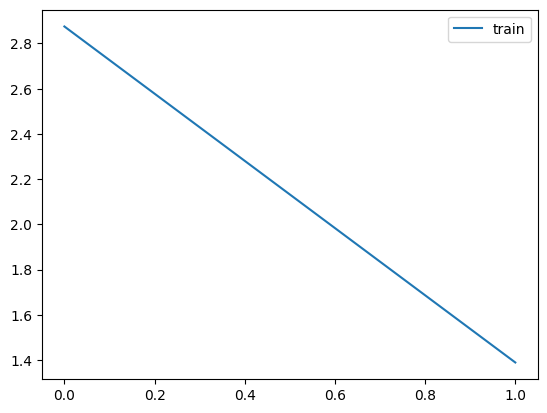

In [10]:
plt.plot(hist.history['loss'], label='train')

plt.legend()
plt.show()

### Inference

In [11]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [12]:
reverse_target_word_index = token.index_word
reverse_source_word_index = token.index_word
target_word_index = token.word_index

def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index] if sampled_token_index != 0 else "eostok"

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or sampled_token_index == 0:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [13]:
def summarize(text):
    tok = text_to_token([text])
    tok = pad_sequences(tok, max_len, padding="post")
    return decode_sequence(tok[0].reshape(1, max_len))

In [14]:
sent = ["New jobless numbers are a bit of a mixed bag for President Obama and his reelection bid",
        "A car filled with Christmas presents was stolen from a home in Melbourne\u2019s north-east on Christmas Day",
        "A mariachi band has serenaded Donald Trump on the sidewalk outside Trump Tower in New York City",
        "Lena Dunham was taken to the hospital Saturday and will undergo surgery for a ruptured ovarian cyst, her spokeswoman said",
        "At least 13 people are reportedly dead and many more are seriously injured after a tour bus collided with a semi-trailer in California",
        "A Chicago cop is being praised for his good deed after an image of him buying a homeless man Chipotle went viral.",
        "Coffee could be extinct by 2080 because of the effects of climate change on coffee growing regions",
        "An American student and part-time model was found dead in her room at an Australian university, a police spokesman said.",
        "The Apple Watch will be available in retail stores in two weeks, Apple announced Thursday",
        "The death of a teenager found in a North Austin parking lot with multiple cobra bites has been ruled a suicide",
        "A man has been charged with murder after a body was found in a home in Sydney's south yesterday",
        "Glen Campbell is suffering from Alzheimer\u2019s disease, the singer revealed to People.",
        "Asbestos has been found in the charred remains of a beach house, gutted by a ferocious fire overnight in Palm Beach on Sydney's Northern Beaches.",
        "Paris Hilton Arrested for Cocaine in Las Vegas was arrested for possession of cocaine Friday night in Las Vegas.",
        "A body pulled from Lake Michigan has been identified as missing medical student Ambrose Monye, who disappeared weeks before his graduation, Chicago police confirmed to FoxNews.com Thursday"
        ]

for s in sent:
    print(summarize(s))

 to in in in
 to in in in
 to in in in
 to in in in
 to in in in
 to in in in
 to in in in
 to in in in
 to in in in
 to in in in
 to in in in
 to in in in
 to in in in
 to in in in
 to in in in
